## 사전 훈련된 Word2Vec을 이용한 영어-한국어 번역 모형

In [1]:
import os
os.chdir('C:/Users/HK/Desktop/GitHub/Deep-Learning/NLP')

import gensim
import nltk
import konlpy
import keras
import numpy as np
import pandas as pd

Using TensorFlow backend.


> ### 사전 훈련된 워드벡터 준비

- 언어별 Word2Vec 불러오기

In [2]:
from gensim.models import Word2Vec
korvec = Word2Vec.load('datasets/ko.bin')

C:\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [3]:
from gensim.models import KeyedVectors
engvec = KeyedVectors.load_word2vec_format('datasets/GoogleNews-vectors-negative300.bin', binary = True)

> ### 데이터 준비

- 출처: Manythings.org http://www.manythings.org/anki/kor-eng.zip

In [4]:
lines = pd.read_table('datasets/kor.txt', names = ['source', 'target'])
print(len(lines), 'observations')
lines.sample(10)

909 observations


,source,target
591,I can not answer your question.,나는 네 질문에 답할 수 없어.
734,When does your winter vacation begin?,겨울 방학은 언제 시작하나요?
256,"Are these yours, Tom?","탐, 이것들이 너의 것이야?"
63,Grab the rope.,로프를 잡으세요.
492,Would you mind if I helped?,내가 도와도 괜찮겠니?
176,Take the medicine.,그 약을 먹으세요.
381,Tom certainly thinks so.,톰은 틀림없이 그렇게 생각해.
337,I'm just doing my best.,난 그저 최선을 다하고 있을 뿐이다.
898,How can anyone trust anything Tom says? He's a...,어떻게 누군가가 톰이 말하는 것을 믿을 수 있지? 그는 병적인 거짓말쟁이야.
501,I know what Tom needs to do.,나는 톰이 무엇을 할 필요가 있는지 알고 있다.


In [5]:
lines.target = lines.target.apply(lambda x : '<sos> ' + x + ' <eos>')
lines.sample(10)

,source,target
625,She committed suicide yesterday.,<sos> 어제 그녀는 자살했다. <eos>
91,Only God knows.,<sos> 신만이 아실 것입니다. <eos>
891,I can smell Mary's perfume. She must have been...,<sos> 나는 메리의 향수 냄새를 맡을 수 있다. 그녀는 좀 전에 여기에 있었음에...
380,This dictionary is mine.,<sos> 이 사전은 내 것이다. <eos>
440,Let me help you with that.,<sos> 내가 도와줄게. <eos>
108,He came at dawn.,<sos> 그는 새벽에 왔다. <eos>
471,Leave the book where it is.,<sos> 책을 제자리에 놔 두세요. <eos>
778,You can't expect much sympathy from Tom.,<sos> 너는 톰에게서 많은 동정심을 바랄 수는 없다. <eos>
285,What are you washing?,<sos> 당신은 무엇을 씻고 있습니까? <eos>
34,I don't lie.,<sos> 나는 거짓말 하지 않습니다. <eos>


In [6]:
from keras.preprocessing.text import Tokenizer

In [7]:
source_t = Tokenizer()
source_t.fit_on_texts(lines.source)
source_vocab_size = len(source_t.word_index) + 1

target_t = Tokenizer()
target_t.fit_on_texts(lines.target)
target_vocab_size = len(target_t.word_index) + 1

In [8]:
print(source_vocab_size)
print(target_vocab_size)

1170
2049


In [9]:
encoder_input_data = source_t.texts_to_sequences(lines.source)
source_max_length = max(len(l) for l in encoder_input_data)

decoder_input_data = target_t.texts_to_sequences(lines.target)
decoder_target_data = [l[1:] for l in decoder_input_data]
target_max_length = max(len(l) for l in decoder_input_data)

In [10]:
print(source_max_length)
print(target_max_length)

19
17


In [11]:
# sample
print(encoder_input_data[0])
print(decoder_input_data[0])
print(decoder_target_data[0])

[92]
[1, 264, 2]
[264, 2]


In [12]:
from keras.preprocessing.sequence import pad_sequences

In [13]:
encoder_input_data = pad_sequences(
    encoder_input_data, maxlen = source_max_length, padding = 'post')
decoder_input_data = pad_sequences(
    decoder_input_data, maxlen = target_max_length, padding = 'post')
decoder_target_data = pad_sequences(
    decoder_target_data, maxlen = target_max_length, padding = 'post')

In [14]:
from keras.utils import to_categorical

In [15]:
decoder_target_data = to_categorical(decoder_target_data)

In [16]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(909, 19)
(909, 17)
(909, 17, 2049)


In [17]:
encoder_embedding_dim = engvec.vector_size
encoder_pretrained_embedding = np.zeros((source_vocab_size, encoder_embedding_dim))

for word, i in source_t.word_index.items():
    if engvec.vocab.get(word) is not None:
        encoder_pretrained_embedding[i] = engvec.get_vector(word)

In [18]:
print(encoder_pretrained_embedding.shape)

(1170, 300)


In [19]:
decoder_embedding_dim = korvec.vector_size
decoder_pretrained_embedding = np.zeros((target_vocab_size, decoder_embedding_dim))

n = 0
for word, i in target_t.word_index.items():
    if korvec.wv.vocab.get(word) is not None:
        decoder_pretrained_embedding[i] = korvec.wv.get_vector(word)
        n += 1

In [20]:
print(decoder_pretrained_embedding.shape)
print(n)
# 조사 때문에 너무 적다..

(2049, 200)
344


> ### 시퀀스-투-시퀀스 모델

In [35]:
from keras.layers import Input, GRU, LSTM, Embedding, Dense
from keras.models import Model, load_model, save_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras import initializers
import keras.backend as K

K.clear_session()

In [36]:
encoder_embedding_layer = Embedding(input_dim = source_vocab_size, 
                                    output_dim = encoder_embedding_dim,
                                    input_length = source_max_length,
                                    weights = [encoder_pretrained_embedding],
                                    trainable = False)
decoder_embedding_layer = Embedding(input_dim = target_vocab_size, 
                                    output_dim = decoder_embedding_dim,
                                    input_length = target_max_length,
                                    weights = [decoder_pretrained_embedding],
                                    trainable = False)

In [37]:
units = 64

encoder_inputs = Input((None,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_rnn = LSTM(units = units, return_state = True)
encoder_outputs, state_h, state_c = encoder_rnn(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input((None,))
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_rnn = LSTM(units = units, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_rnn(decoder_embedding, initial_state = encoder_states)

decoder_softmax_layer = Dense(target_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [38]:
model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.rmsprop(),
              metrics = ['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 19, 300)      351000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 200)      409800      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [39]:
epochs = 300
batch_size = 128

modelpath = 'models/pretrained-word2vec-eng-to-kor.hdf5'
check = ModelCheckpoint(modelpath, monitor = 'val_acc', save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_acc', patience = 50)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    validation_split = 0.2,
                    callbacks = [check, early],
                    epochs = epochs, batch_size = batch_size, verbose = 2)

Train on 727 samples, validate on 182 samples
Epoch 1/300
 - 5s - loss: 7.4803 - acc: 0.5799 - val_loss: 6.6581 - val_acc: 0.5711
Epoch 2/300
 - 3s - loss: 5.7337 - acc: 0.7315 - val_loss: 5.4128 - val_acc: 0.5692
Epoch 3/300
 - 4s - loss: 4.3123 - acc: 0.7315 - val_loss: 4.4514 - val_acc: 0.5692
Epoch 4/300
 - 4s - loss: 3.2488 - acc: 0.7315 - val_loss: 3.9247 - val_acc: 0.5692
Epoch 5/300
 - 4s - loss: 2.6892 - acc: 0.7315 - val_loss: 3.6542 - val_acc: 0.5692
Epoch 6/300
 - 4s - loss: 2.3817 - acc: 0.7315 - val_loss: 3.4753 - val_acc: 0.5692
Epoch 7/300
 - 3s - loss: 2.1899 - acc: 0.7315 - val_loss: 3.3719 - val_acc: 0.5692
Epoch 8/300
 - 3s - loss: 2.0608 - acc: 0.7315 - val_loss: 3.3251 - val_acc: 0.5692
Epoch 9/300
 - 3s - loss: 1.9693 - acc: 0.7315 - val_loss: 3.2962 - val_acc: 0.5692
Epoch 10/300
 - 3s - loss: 1.9032 - acc: 0.7315 - val_loss: 3.3181 - val_acc: 0.5692
Epoch 11/300
 - 3s - loss: 1.8502 - acc: 0.7315 - val_loss: 3.2888 - val_acc: 0.5692
Epoch 12/300
 - 3s - loss: 1

Epoch 97/300
 - 3s - loss: 1.0917 - acc: 0.7991 - val_loss: 4.3631 - val_acc: 0.5963
Epoch 98/300
 - 3s - loss: 1.0748 - acc: 0.8034 - val_loss: 4.3512 - val_acc: 0.5976
Epoch 99/300
 - 3s - loss: 1.0854 - acc: 0.8009 - val_loss: 4.3916 - val_acc: 0.5960
Epoch 100/300
 - 3s - loss: 1.0684 - acc: 0.8044 - val_loss: 4.4110 - val_acc: 0.5963
Epoch 101/300
 - 3s - loss: 1.0756 - acc: 0.8004 - val_loss: 4.3677 - val_acc: 0.5966
Epoch 102/300
 - 3s - loss: 1.0483 - acc: 0.8085 - val_loss: 4.3694 - val_acc: 0.5973
Epoch 103/300
 - 3s - loss: 1.0636 - acc: 0.8032 - val_loss: 4.3982 - val_acc: 0.5979
Epoch 104/300
 - 3s - loss: 1.0430 - acc: 0.8082 - val_loss: 4.4052 - val_acc: 0.5953
Epoch 105/300
 - 3s - loss: 1.0541 - acc: 0.8039 - val_loss: 4.3900 - val_acc: 0.5973
Epoch 106/300
 - 3s - loss: 1.0287 - acc: 0.8116 - val_loss: 4.3418 - val_acc: 0.5976
Epoch 107/300
 - 3s - loss: 1.0446 - acc: 0.8061 - val_loss: 4.2439 - val_acc: 0.5941
Epoch 108/300
 - 3s - loss: 1.0333 - acc: 0.8083 - val_lo

Epoch 193/300
 - 4s - loss: 0.6683 - acc: 0.8617 - val_loss: 4.7142 - val_acc: 0.6021
Epoch 194/300
 - 4s - loss: 0.6926 - acc: 0.8553 - val_loss: 4.7272 - val_acc: 0.6028
Epoch 195/300
 - 5s - loss: 0.6740 - acc: 0.8590 - val_loss: 4.6684 - val_acc: 0.6044
Epoch 196/300
 - 4s - loss: 0.6636 - acc: 0.8626 - val_loss: 4.6719 - val_acc: 0.6041
Epoch 197/300
 - 5s - loss: 0.6589 - acc: 0.8638 - val_loss: 4.6709 - val_acc: 0.5983
Epoch 198/300
 - 5s - loss: 0.6849 - acc: 0.8539 - val_loss: 4.7045 - val_acc: 0.6028
Epoch 199/300
 - 5s - loss: 0.6515 - acc: 0.8645 - val_loss: 4.7501 - val_acc: 0.6015
Epoch 200/300
 - 5s - loss: 0.6567 - acc: 0.8624 - val_loss: 4.7676 - val_acc: 0.5995
Epoch 201/300
 - 4s - loss: 0.6552 - acc: 0.8637 - val_loss: 4.6996 - val_acc: 0.5999
Epoch 202/300
 - 4s - loss: 0.6560 - acc: 0.8615 - val_loss: 4.7478 - val_acc: 0.6005
Epoch 203/300
 - 3s - loss: 0.6485 - acc: 0.8641 - val_loss: 4.7410 - val_acc: 0.6012
Epoch 204/300
 - 3s - loss: 0.6360 - acc: 0.8671 - val

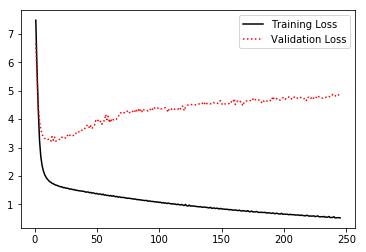

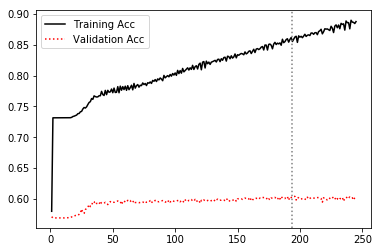

epoch 194: Training Acc = 85.9%, Validation Acc = 60.440000000000005%


In [43]:
import matplotlib.pyplot as plt

def history_plot(history):
    epoch = range(1, len(history.history['loss']) + 1)
    m = np.argmax(history.history['val_acc'])
    
    plt.plot(epoch, history.history['loss'], '-k', label = 'Training Loss')
    plt.plot(epoch, history.history['val_loss'], ':r', label = 'Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(epoch, history.history['acc'], '-k', label = 'Training Acc')
    plt.plot(epoch, history.history['val_acc'], ':r', label = 'Validation Acc')
    plt.axvline(m, linestyle = ':', color = 'gray')
    plt.legend()
    plt.show()
    
    print('epoch {}: Training Acc = {}%, Validation Acc = {}%'.
          format(m, np.round(history.history['acc'][m], 4)*100, np.round(history.history['val_acc'][m], 4)*100))

history_plot(history)

In [44]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (units,))
decoder_state_input_c = Input(shape = (units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedded_p = decoder_embedding_layer(decoder_inputs)
decoder_outputs_p, state_h_p, state_c_p = decoder_rnn(
    decoder_embedded_p, initial_state = decoder_states_inputs)

decoder_states_p = [state_h_p, state_c_p]
decoder_outputs_p = decoder_softmax_layer(decoder_outputs_p)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, 
                      [decoder_outputs_p] + decoder_states_p)

In [45]:
index_to_source = dict((i, char) for char, i in source_t.word_index.items())
index_to_target = dict((i, char) for char, i in target_t.word_index.items())

In [46]:
def decode_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_t.word_index['sos']
    
    stop_condition = False
    decoded_sentence = ''
    
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition: 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_target[sampled_token_index]
        decoded_sentence += ' ' + sampled_char
        
        # 문장 끝에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == 'eos' or
           len(decoded_sentence) > target_max_length):
            stop_condition = True
        
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트
        states_value = [h, c]
        
    return decoded_sentence